In [1]:
import os
from dotenv import load_dotenv

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from langchain_milvus import Milvus
from typing_extensions import List, TypedDict, Optional
from langchain_core.documents import Document
import uuid
import json

In [3]:
load_dotenv()

True

In [4]:
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "manuals"

In [5]:
milvus_uri = f"http://{MILVUS_HOST}:{MILVUS_PORT}"
connection_args = {"uri": milvus_uri}

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [7]:
prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
    Você é um assistente especialista em responder perguntas sobre manuais automotivos.  
    – Use apenas o conteúdo fornecido no contexto. Se a resposta não estiver lá, diga “Não sei, não tenho essa informação”.
    – Responda em **no máximo cinco frases**, sendo conciso e preciso.  
    – **Sempre indique a localização exata** de qualquer componente ou controle mencionado, caso aplicável.
    – Dê instruções claras, passo a passo, quando aplicável.
    - Não mencione o número da página.
    - Evite responder mais do que o necessário.
    - Não faça suposições ou adivinhações.

    Pergunta: {question}
    Contexto: {context}
    Resposta:
    """)
])

In [8]:
vectorstore = Milvus(
    collection_name=MILVUS_COLLECTION_NAME,
    embedding_function=embeddings,
    connection_args=connection_args,
    auto_id=True,
    consistency_level="Strong",
    search_params={"metric_type": "L2", "params": {"nprobe": 10}}
)

In [9]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    brand: Optional[str]
    model: Optional[str]
    year: Optional[int]

In [10]:
def retrieve(state: State):
    """
    Retrieve relevant documents from the vectorstore based on the question and optional filters.
    
    Args:
        state (State): The current state containing the question and optional filters (brand, model, year).
        
    Returns:
        dict: A dictionary containing the retrieved context, question, and any filters applied.
    """
    question = state["question"]
    brand = state.get("brand")
    model = state.get("model")
    year = state.get("year")

    filter_conditions = []
    if brand:
        filter_conditions.append(f'brand == "{brand}"')
    if model:
        filter_conditions.append(f'model == "{model}"')
    if year:
        filter_conditions.append(f'year == "{year}"')

    # Ex: 'brand == "Ford" and model == "Ranger" and year == 2023'
    filter_expr = " and ".join(filter_conditions) if filter_conditions else None

    if filter_expr:
        retrieved_docs = vectorstore.similarity_search(
            query=question,
            k=10,
            expr=filter_expr 
        )
    else:
        retrieved_docs = vectorstore.similarity_search(query=question, k=10)
    
    return {
        "context": retrieved_docs,
        "question": question,
        "brand": brand,
        "model": model,
        "year": year,
        "answer": ""
    }


def generate(state: State):
    """
    Generate an answer based on the retrieved context and the question.
    Args:
        state (State): The current state containing the question and retrieved context.
    Returns:
        dict: A dictionary containing the generated answer.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [11]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

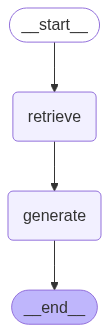

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
def save_response_json(resposta_final: dict, filename: str = "resultados_rag_vw.json", modelo_rag: str = "rag"):
    """
    Gets the final response from the RAG process and saves it to a JSON file.
    
    Args:
        resposta_final (dict): The final response dictionary containing the question, context, and answer.
        filename (str): The name of the JSON file to save the results. Defaults to 'resultados_rag.json'.
        
    Returns:
        None: The function saves the response to a JSON file and does not return anything.
    """
    
    resultado = {
        "id_pergunta": f"P_{str(uuid.uuid4())[:8]}",
        "pergunta_usuario": resposta_final["question"],
        "contexto_recuperado": "\n\n".join(doc.page_content for doc in resposta_final["context"]),
        "resposta_gerada": resposta_final["answer"],
        "modelo_rag": modelo_rag,
        "metadados": {
            "marca": resposta_final.get("brand"),
            "modelo": resposta_final.get("model"),
            "ano": resposta_final.get("year")
        }
    }

    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lista_resultados = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        lista_resultados = []
        
    lista_resultados.append(resultado)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(lista_resultados, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Resposta salva com sucesso em '{filename}'")

## **Questions** 

### **Volkswagen**

In [53]:
question = [
    "Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?", # 1
    "Como eu conecto meu celular Android no carro para usar os aplicativos na tela?", # 2
    "Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?", # 3
    "A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?", # 4
    "Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?", # 5
    "Como eu ajusto a hora no painel do carro?", # 6
    "Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?", # 7
    "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", # 8
    "Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?", # 9
    "Quando é a próxima revisão do carro? É por tempo ou por quilometragem?" # 10
]

### 1 - Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?

In [54]:
response = graph.invoke({"question": question[0], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
           

In [55]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
A luz amarela com o desenho de um motor indica uma avaria na unidade de controle do motor (Electronic Power Control). Você deve verificar o motor imediatamente, preferencialmente em uma Concessionária Volkswagen. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e dirigir com cuidado até a concessionária mais próxima. Não ignore essa luz, pois pode causar danos ao veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 2 - Como eu conecto meu celular Android no carro para usar os aplicativos na tela?

In [56]:
response = graph.invoke({"question": question[1], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 6 channels:
- context -> [Document(metadata=

In [57]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
Para conectar seu celular Android ao carro e usar os aplicativos na tela, siga estes passos: 

1. Verifique se seu telefone suporta o Android Auto™ e se o aplicativo necessário está instalado.
2. Conecte o telefone ao rádio usando um cabo USB original do fabricante.
3. Quando conectado pela primeira vez, siga as instruções exibidas no display do rádio e no telefone.
4. Pressione o botão do rádio para acessar as funções do Android Auto™.
5. Selecione seu telefone pressionando o ícone correspondente no menu APP.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 3 - Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?

In [58]:
response = graph.invoke({"question": question[2], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:w

In [59]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
A calibragem certa dos pneus pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta indica a pressão dos pneus para o eixo dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado mais que alguns quilômetros. Calibre os pneus de acordo com os dados indicados na etiqueta e nunca exceda a pressão máxima indicada no flanco dos pneus.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 4 - A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?

In [60]:
response = graph.invoke({"question": question[3], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': 

In [61]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
A luz do freio acesa em vermelho e apitando indica uma situação de perigo. Não é seguro continuar a conduzir; você deve parar o veículo assim que possível em um local seguro. A luz pode indicar um nível de fluido de freio muito baixo ou um sistema de freio avariado. É recomendado verificar a função avariada e, se necessário, procurar uma concessionária Volkswagen para assistência técnica.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 5 - Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?

In [62]:
response = graph.invoke({"question": question[4], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[1:tasks] Starting 1 ta

In [63]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
O sistema Start-Stop desliga automaticamente o motor ao parar o veículo e o liga novamente quando necessário. Para utilizá-lo, basta pisar no pedal do freio e mantê-lo pressionado; o motor se desligará. Para reiniciar o motor, retire o pé do freio ou pise no acelerador. É recomendável desligar o sistema manualmente ao atravessar trechos alagados ou em situações de espera prolongada, como em uma passagem de nível. Não se deve deixar a ignição ligada com o motor desligado por longos períodos, pois isso pode descarregar a bateria.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 6 - Como eu ajusto a hora no painel do carro?

In [64]:
response = graph.invoke({"question": question[5], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 6 channels:
- context -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo d

In [65]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
Para ajustar a hora no painel do carro, siga um dos métodos abaixo:

1. **Através do rádio**: Pressione o botão do rádio, toque na superfície de função para abrir o menu Configurações do veículo, selecione Hora e data e ajuste o horário com os botões de seta.

2. **Através do instrumento combinado digital**: No menu Dados de viagem, selecione o indicador Autonomia, mantenha pressionado o botão OK no volante por cerca de cinco segundos, selecione o menu Hora e ajuste o relógio com os botões de seta.

3. **Através do instrumento combinado analógico**: Ligue a ignição, pressione o botão no instrumento combinado para selecionar o indicador das horas, ajuste as horas e minutos pressionando brevemente os botões correspondentes e finalize pressionando novamente o botão.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 7 - Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?

In [66]:
response = graph.invoke({"question": question[6], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:writes] Finished step 1 with 

In [67]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
O macaco e as ferramentas para trocar o pneu estão localizados no compartimento de bagagem do veículo. Para trocar o pneu, siga estes passos: 1) Estacione o veículo em um local seguro e desligue o motor. 2) Solte os parafusos da roda a ser trocada, mas não os retire completamente. 3) Coloque o macaco sob o ponto de apoio mais próximo da roda a ser trocada e levante o veículo até que a roda fique suspensa. 4) Remova os parafusos e a roda danificada, coloque a roda de emergência, aperte os parafusos e abaixe o veículo. 5) Após a troca, verifique o torque dos parafusos com um torquímetro.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 8 - O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?

In [68]:
response = graph.invoke({"question": question[7], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a difer

In [69]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
O modo 'Eco' é projetado para baixo consumo de combustível e uma condução econômica, enquanto o modo 'Sport' oferece uma experiência de condução mais esportiva, alterando até o som do motor. Para selecionar o perfil de condução, ligue a ignição e, com o veículo parado, acesse a tela principal do rádio, arraste para a esquerda e selecione "Modo de condução". Você também pode usar o volante multifunções, pressionando o botão correspondente para acessar a área do perfil de informação e, em seguida, escolher o perfil desejado. Se estiver dirigindo, tire rapidamente o pé do acelerador para que o novo perfil também seja ativado para o motor.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 9 - Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?

In [70]:
response = graph.invoke({"question": question[8], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no man

In [71]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
Sim, o seu Polo pode puxar um reboque, desde que esteja equipado com um dispositivo de reboque adequado. Os pontos de fixação para instalar esse dispositivo estão localizados na parte inferior do veículo. É importante seguir as instruções do fabricante do engate e garantir que o dispositivo esteja fixado com segurança. Além disso, respeite sempre a legislação de trânsito vigente e conduza com cautela, especialmente em aclives e ao frear. Para mais informações sobre o reboque, considere utilizar o Volkswagen Service.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### 10 - Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

In [72]:
response = graph.invoke({"question": question[9], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:writes] Finished step 1 with writes to 6 channels:
- context -> [Document(metadata={'model': 'Polo', 'year': '2025'

In [73]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response)


--- Resposta gerada ---
A próxima revisão do carro deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro, em condições normais. Se o veículo for utilizado em condições adversas, a revisão deve ser feita a cada 10.000 km ou 6 meses. O aviso de serviço aparecerá ao ligar a ignição quando um serviço estiver próximo a vencer. É importante seguir rigorosamente os prazos de verificação e substituição para manter a garantia do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_vw.json'


### **Fiat**

In [ ]:
question = [
    "Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?", # 1
    "A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?", # 2
    "Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?", # 3
    "A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?", # 4
    "Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?", # 5
    "As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?", # 6
    "Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?", # 7
    "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", # 8
    "Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?", # 9
    "Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?" # 10
]

### 1- Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?

In [76]:
response = graph.invoke({"question": question[0], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',

In [77]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
O estepe, o macaco e as ferramentas estão localizados no porta-ferramentas B, sob a roda sobressalente. O triângulo de segurança está no porta-malas, próximo ao sistema de travamento da tampa. Para trocar o pneu, siga estes passos: 

1. Estacione o veículo em um local seguro, longe da pista, e ligue as luzes de emergência.
2. Alivie os parafusos da roda furada com a chave de roda, enquanto a roda ainda estiver no chão.
3. Levante o veículo com o macaco até que a roda se eleve do solo.
4. Remova a roda furada e instale a roda sobressalente, apertando os parafusos.
5. Baixe o veículo completamente e guarde o macaco e as ferramentas no porta-ferramentas.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 2 - A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?

In [80]:
response = graph.invoke({"question": question[1], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fi

In [81]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Para fazer a partida do motor com uma bateria auxiliar, siga estes passos: 

1. Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
2. Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
3. Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
4. Conecte a outra extremidade do cabo negativo (-) a uma massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.
5. Ligue o motor do veículo com a bateria auxiliar e, após alguns minutos, ligue o motor do veículo com a bateria descarregada. 

Lembre-se de não conectar o cabo negativo (-) diretamente ao terminal negativo da bateria descarregada.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 3 - Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?

In [82]:
response = graph.invoke({"question": question[2], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:writes] Finished step 1 with writes t

In [83]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Para saber a pressão correta dos pneus do seu carro, consulte o capítulo "Dados Técnicos" do manual, especificamente a seção "Rodas e Pneus". A calibragem deve ser feita com os pneus frios, e a pressão não deve exceder a máxima indicada na parte externa do pneu. Verifique regularmente a pressão dos pneus e do pneu sobressalente, respeitando os valores indicados. Se a luz-espia de pressão acender, verifique a pressão e ajuste conforme necessário. Após o enchimento, realize o reset do sistema de monitoramento de pressão dos pneus.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 4 - A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?

In [84]:
response = graph.invoke({"question": question[3], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 6 channels:
- context -> [Document(met

In [85]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Primeiro, pare o veículo e desligue o motor imediatamente. Não abra o capô até que o radiador tenha esfriado para evitar queimaduras. Verifique o nível do líquido de arrefecimento no reservatório, que deve estar entre as referências MIN e MAX. Se o nível estiver abaixo do mínimo, aguarde o motor esfriar, abra o tampão lentamente e reponha o líquido. Além disso, regule o aquecimento do habitáculo para o máximo e ative o eletroventilador na velocidade máxima para ajudar a dissipar o calor.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 5 - Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?

In [86]:
response = graph.invoke({"question": question[4], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu car

In [87]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Primeiro, verifique se o freio de estacionamento está acionado. Em seguida, gire a chave para a posição MAR e observe se a luz-espia acende. Se a luz-espia não acender ou ficar acesa de forma intermitente, isso pode indicar um problema no sistema de ignição ou no bloqueio do motor. Nesse caso, tente reposicionar a chave na posição STOP e depois novamente em MAR. Se o problema persistir, é recomendável que você dirija-se à Rede Assistencial Fiat.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 6 - As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?

In [89]:
response = graph.invoke({"question": question[5], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luz

In [90]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. Isso indica uma avaria no sistema EBD e pode resultar em travamento precoce das rodas traseiras, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente à Rede Assistencial Fiat para verificação do sistema. Evite esforços do motor e altas velocidades até que o problema seja resolvido.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 7 - Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?

In [91]:
response = graph.invoke({"question": question[6], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 6 channels:
- cont

In [92]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
Se a chave eletrônica for esquecida dentro do veículo, ao tentar trancar as portas, o sistema não permitirá o travamento. Isso ocorre porque o sistema detecta a presença da chave no interior. Para reativar o funcionamento normal, é necessário pressionar o botão no telecomando. Caso as portas tenham sido trancadas mecanicamente ou pelo telecomando, o botão de fechamento centralizado será desabilitado até que as portas sejam destravadas.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 8 - Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?

In [93]:
response = graph.invoke({"question": question[7], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 

In [94]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
O aviso de 'HCSS' indica que o sistema de pré-aquecimento de combustível está ativo, especialmente em temperaturas abaixo de 30°C. É normal que a luz-espia acenda ao abrir a porta do lado do motorista, e você deve aguardar até que a luz-espia se apague antes de dar a partida. Se a luz-espia piscar intermitentemente, isso indica que o sistema está indisponível, e você deve procurar a Rede Assistencial Fiat. Para dar a partida, desligue o veículo, aguarde a luz-espia apagar e tente novamente.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 9 - Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

In [95]:
response = graph.invoke({"question": question[8], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:writes] Finished step 1 with writes to 6 channels:
- context -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo

In [96]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
O tanque de combustível do carro tem capacidade para 47 litros. Incluindo a reserva, que varia de 5,50 a 7,50 litros, a capacidade total fica entre 52,50 e 54,50 litros.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'


### 10 - Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?

In [97]:
response = graph.invoke({"question": question[9], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:writes] Finished step 1 w

In [98]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_fiat.json")


--- Resposta gerada ---
A capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando trocando o filtro, é de 5,50 a 7,50 litros. Para realizar a troca, siga os seguintes passos: 1) Desconecte o filtro de óleo antigo; 2) Instale o novo filtro de óleo genuíno; 3) Adicione o óleo novo na câmara de óleo do motor; 4) Verifique o nível de óleo com a vareta. Certifique-se de que o veículo esteja em uma superfície nivelada durante a verificação.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_fiat.json'
